In [2]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

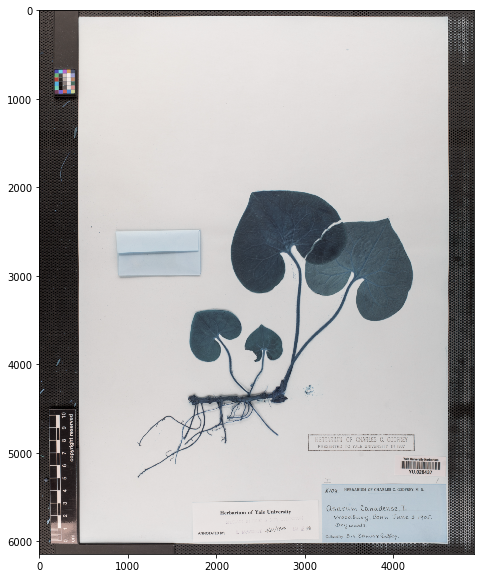

In [3]:
img = cv2.imread('leaf-ex-2.jpg')
#img = np.load('cropped_image.npy').astype('uint8')
#img = img[500:3000, 100:2500]
#img = img[1800:5000, 800:4500]
#img = img[1000:5800, 800:4500]
blur = cv2.GaussianBlur(img, (21, 21), 2)
h, w = img.shape[:2]

fig = plt.figure(figsize=(10,10))
plt.imshow(blur)

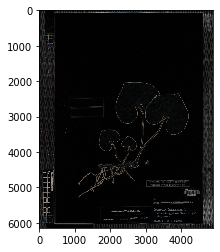

In [4]:
# Morphological gradient
# 1st: Ellipse shaped to put where 1's are 
# 2nd: kernel size
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))

# MORPH_GRADIENT = difference between erosion and dilation
# Will provide the outline of the leaves
gradient = cv2.morphologyEx(blur, cv2.MORPH_GRADIENT, kernel)

#cv2.imshow('Morphological gradient', gradient)
#cv2.waitKey()
plt.imshow(gradient)

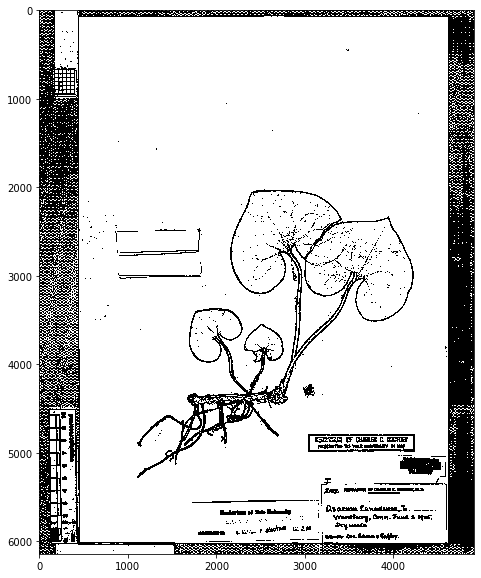

In [5]:
# Binarize gradient
lowerb = np.array([0, 0, 0])
#upperb = np.array([10, 10, 10])
upperb = np.array([15, 15, 15])

#lowerb = np.array([0])
#upperb = np.array([15])


# ?? Creates the mask to threshold for what is edges 
binary = cv2.inRange(gradient, lowerb, upperb)

#cv2.imshow('Binarized gradient', binary)
#cv2.waitKey()

# Why does it look yellow?
fig = plt.figure(figsize=(10,10))
plt.imshow(binary, cmap='gray')

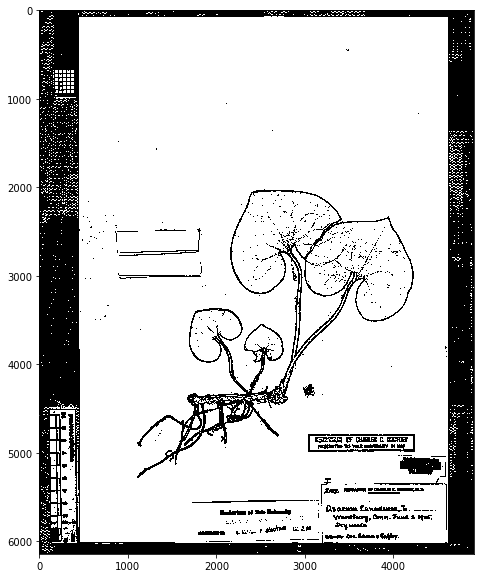

In [6]:
# Flood fill from the edges to remove edge crystals 
# From my understanding, the code below removes edges where we aren't sure where it ends (i.e. things at the edge of the image)
# Not sure if we will need this since we don't have any leaves at the edges of an image

for row in range(h):
    if binary[row, 0] == 255:
        cv2.floodFill(binary, None, (0, row), 0)
    if binary[row, w-1] == 255:
        cv2.floodFill(binary, None, (w-1, row), 0)
        
for col in range(w):
    if binary[0, col] == 255:
        cv2.floodFill(binary, None, (col, 0), 0)
    if binary[h-1, col] == 255:
        cv2.floodFill(binary, None, (col, h-1), 0)

#cv2.imshow('Filled binary gradient', binary)
#cv2.waitKey()
fig = plt.figure(figsize=(10,10))
plt.imshow(binary, cmap='gray')

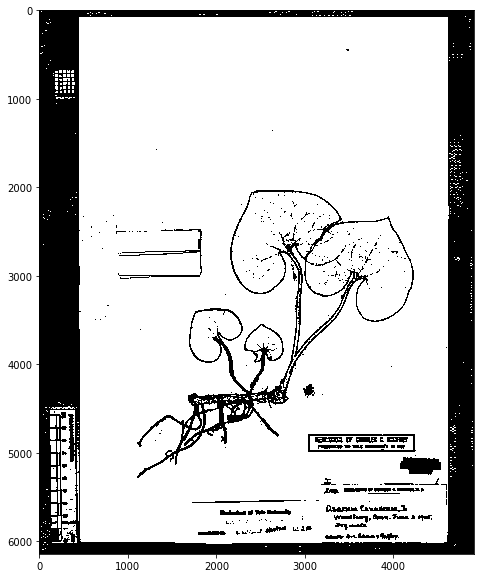

In [7]:
# Cleaning up mask

# Erosion followed by Dilation
foreground = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

# Dilation followed by Erosion
foreground = cv2.morphologyEx(foreground, cv2.MORPH_CLOSE, kernel)

#cv2.imshow('Cleanup up crystal foreground mask', foreground)
#cv2.waitKey()

fig = plt.figure(figsize=(10,10))
plt.imshow(foreground, cmap = 'gray')

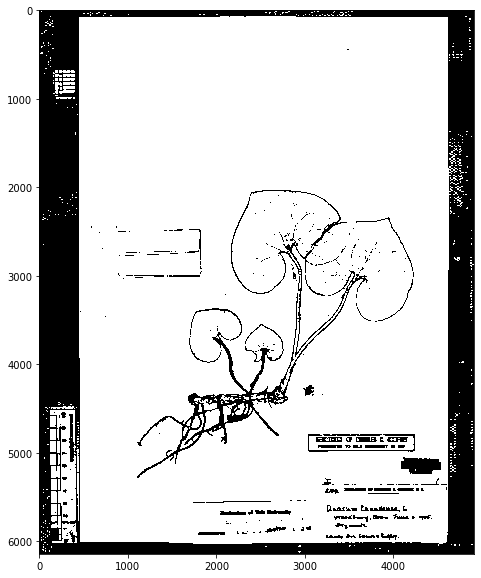

In [8]:
# Creating background and unknown mask for labeling

#kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
background = cv2.dilate(foreground, kernel, iterations=3)
unknown = cv2.subtract(background, foreground)

#cv2.imshow('Background', background)
#cv2.waitKey()
fig = plt.figure(figsize=(10,10))


plt.imshow(background, cmap = 'gray')

In [9]:
background

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
# Watershed

markers = cv2.connectedComponents(foreground)[1]
markers += 1  # Add one to all labels so that background is 1, not 0
markers[unknown==255] = 0  # mark the region of unknown with zero
markers = cv2.watershed(img, markers)

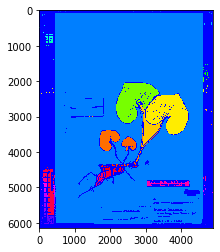

In [11]:
# Assign the markers a hue between 0 and 179

hue_markers = np.uint8(179*np.float32(markers)/np.max(markers))
blank_channel = 255*np.ones((h, w), dtype=np.uint8)
marker_img = cv2.merge([hue_markers, blank_channel, blank_channel])
marker_img = cv2.cvtColor(marker_img, cv2.COLOR_HSV2BGR)

#cv2.imshow('Colored markers', marker_img)
#cv2.waitKey()

plt.imshow(marker_img)

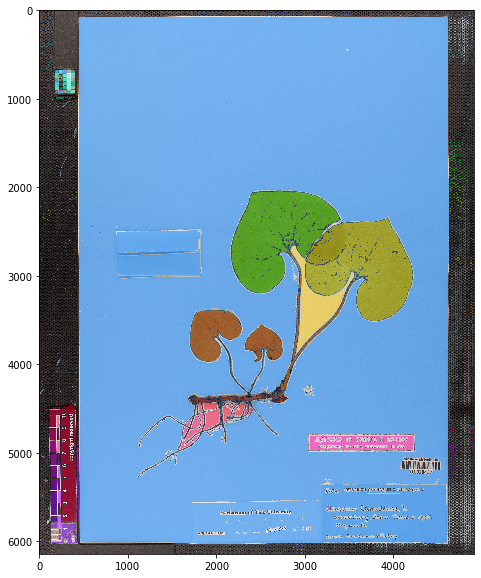

In [12]:
# Label the original image with the watershed markers

labeled_img = img.copy()
labeled_img[markers>1] = marker_img[markers>1]  # 1 is background color
labeled_img = cv2.addWeighted(img, 0.5, labeled_img, 0.5, 0)

#cv2.imshow('watershed_result.png', labeled_img)
#cv2.waitKey()
fig = plt.figure(figsize=(10,10))
plt.imshow(labeled_img)